In [ ]:
%%capture
!pip install wandb

In [ ]:
import sys
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torchvision.io as io

import seaborn as sns

from PIL import Image

from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import random_split
from torchsummary import summary
from torchvision.transforms.transforms import CenterCrop

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

import wandb

In [ ]:
os.environ['WANDB_MODE'] = 'online'
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

### Insert file path HERE ###
PATHNAME = "/content/drive/MyDrive/Accounts/DIU/Seabed_Objects_Demo"
assert PATHNAME is not None, "[!] Enter the foldername."

using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### INSERT User Inputs HERE ###

# Location of images
full_data_directory = PATHNAME + '/unbalanced_training_validation_set'
balanced_data_directory = PATHNAME + '/balanced_training_validation_set'
test_data_directory = PATHNAME + '/test_set'

In [ ]:
with wandb.init(entity="awesome-team", project="diu-phase2-demo", job_type="load-data") as run:
    raw_unbalanced = wandb.Artifact('raw-unbalanced', type='dataset')
    raw_unbalanced.add_dir(full_data_directory)
    raw_balanced = wandb.Artifact('raw-balanced', type='dataset')
    raw_balanced.add_dir(balanced_data_directory)
    raw_test = wandb.Artifact('raw-test', type='dataset')
    raw_test.add_dir(test_data_directory)

    run.log_artifact(raw_unbalanced)
    run.log_artifact(raw_balanced)
    run.log_artifact(raw_test)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Adding directory to artifact (/content/drive/MyDrive/Accounts/DIU/Seabed_Objects_Demo/unbalanced_training_validation_set)... Done. 38.7s
wandb: Adding directory to artifact (/content/drive/MyDrive/Accounts/DIU/Seabed_Objects_Demo/balanced_training_validation_set)... Done. 7.0s
wandb: Adding directory to artifact (/content/drive/MyDrive/Accounts/DIU/Seabed_Objects_Demo/test_set)... Done. 19.3s


In [ ]:
# Log raw unbalanced and balanced data for exploration (do this once for demo)
with wandb.init(entity="awesome-team", project="diu-phase2-demo", job_type="raw-data-table") as run:
  balanced_table = wandb.Table(columns=["filename", "image", "label"])
  unbalanced_table = wandb.Table(columns=["filename", "image", "label"])
  test_table = wandb.Table(columns=["filename", "image", "label"])

  for label in os.listdir(full_data_directory):
    for image in os.listdir(full_data_directory + "/" + label):
        unbalanced_table.add_data(image,
                            wandb.Image(full_data_directory + "/" + label + "/" + image),
                            label)

  for label in os.listdir(balanced_data_directory):
    for image in os.listdir(balanced_data_directory + "/" + label):
        balanced_table.add_data(image,
                            wandb.Image(balanced_data_directory + "/" + label + "/" + image),
                            label)

  for label in os.listdir(test_data_directory):
    for image in os.listdir(test_data_directory + "/" + label):
        test_table.add_data(image,
                            wandb.Image(test_data_directory + "/" + label + "/" + image),
                            label)

  wandb.log({"full_dataset": unbalanced_table})
  wandb.log({"balanced_dataset": balanced_table})
  wandb.log({"test_dataset": test_table})

wandb: Currently logged in as: kevin-stofan (awesome-team). Use `wandb login --relogin` to force relogin


In [ ]:
config = {
    'method': 'random',
    # 'metric': {
    #     'name': train_loss,
    #     'goal': minimize
    # },
    'parameters': {
        'pxls': {
            'value': 150
        },
        'bs': {
            'values': [50, 100, 150, 200, 250, 300, 350, 400]
        },
        'num_epochs': {
            'distribution': 'int_uniform',
            'min': 20,
            'max': 40
        },
        'rate': {
            'distribution': 'uniform',
            'min': .0001,
            'max': .1
        },
        'balanced': {
            'values': [0, 1]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(config, entity="awesome-team", project="diu-phase2-demo")

Create sweep with ID: hc69lhb2
Sweep URL: https://wandb.ai/awesome-team/diu-phase2-demo/sweeps/hc69lhb2


In [ ]:
classes = {
    0: "Plane",
    1: "Seafloor",
    2: "Ship"
}

In [ ]:
def build_transforms(pxls):
    # Additional transforms to consider for the training set:
    # RandomRotation, RandomHorizontalFlip, CenterCrop

    image_transforms = transforms.Compose([
        transforms.Resize(size=(pxls, pxls)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    return image_transforms

In [ ]:
def log_split_dataset(train, val):
    train_split = wandb.Artifact('train_split', type='dataset')
    val_split = wandb.Artifact('val_split', type='dataset')

    for train_image in train.dataset.samples:
        train_split.add_file(train_image[0])

    for val_image in val.dataset.samples:
        train_split.add_file(val_image[0])

    wandb.log_artifact(train_split)
    wandb.log_artifact(val_split)

In [ ]:
def build_dataset(pxls, bs, balanced):
    if balanced == False:
      images = datasets.ImageFolder(root=full_data_directory, transform=build_transforms(pxls))
      # Random split of training, validation sets (80/20)
      num_items = len(images)
      num_train = round(num_items * 0.8)
      num_val = num_items - num_train
      train_ds, val_ds = random_split(images, [num_train, num_val])
    else:
      images = datasets.ImageFolder(root=balanced_data_directory, transform=build_transforms(pxls))
      # Random split of training, validation sets (80/20)
      num_items = len(images)
      num_train = round(num_items * 0.8)
      num_val = num_items - num_train
      train_ds, val_ds = random_split(images, [num_train, num_val])

    test_ds = datasets.ImageFolder(root=test_data_directory, transform=build_transforms(pxls))

    log_split_dataset(train_ds, val_ds)

    return train_ds, val_ds, test_ds

In [ ]:
def build_data_loaders(pxls, bs, balanced):
    train_ds, val_ds, test_ds = build_dataset(pxls, bs, balanced)
    # Create training, validation, and test data loaders
    train_data = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
    valid_data = torch.utils.data.DataLoader(val_ds, batch_size=bs, shuffle=False)
    test_data = torch.utils.data.DataLoader(test_ds, batch_size=bs, shuffle=False)

    # # Size of data, to be used for calculating average Loss and accuracy
    # train_data_size = len(train_ds)
    # valid_data_size = len(val_ds)
    # test_data_size = len(test_ds)

    # Print the training, validation, and test set data sizes
    # train_data_size, valid_data_size, test_data_size
    return train_data, valid_data, test_data

In [ ]:
def build_model():
    config = wandb.config
    # Load pretrained ResNet50 Model
    resnet50 = models.resnet50(pretrained=True)

    # Freeze model parameters
    for param in resnet50.parameters():
        param.requires_grad = False

    # Modify the final layer
    fc_inputs = resnet50.fc.in_features
    resnet50.fc = nn.Sequential(
        nn.Linear(fc_inputs, 256),
        nn.ReLU(),
        nn.Linear(256, 3)
    )

    model_CE = copy.deepcopy(resnet50)
    model_artifact = wandb.Artifact(
        "pretrained_resnet50", type="model",
        description="Pre-trained resnet with modified final layer",
        metadata=dict(config)
    )

    torch.save(model_CE.state_dict(), "initialized_model.pth")
    model_artifact.add_file("initialized_model.pth")
    wandb.log_artifact(model_artifact)
    return model_CE

In [ ]:
def build_optimizer(lr, model):
    optimizer_CE = optim.Adam(model.parameters(), lr=lr)
    return optimizer_CE

# Use Cross Entropy loss as a starting point
def cross_entropy_loss(outputs, labels):
    loss_func = nn.CrossEntropyLoss()
    return(loss_func(outputs, labels))

def cross_entropy_preds(outputs):
    ret, predictions = torch.max(outputs.data, 1)
    return predictions

def check_val_accuracy(model, valid_data, loss_func, predict_func):
    # No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        valid_data_size = len(valid_data.dataset)
        # Validation loop
        valid_loss = 0
        valid_acc = 0
        for j, (inputs, labels) in enumerate(valid_data):
              inputs = inputs.to(device)
              labels = labels.to(device)
              # Forward pass - compute outputs on input data using the model
              outputs = model(inputs)
              # Compute loss
              loss = loss_func(outputs, labels)
              # Compute the total loss for the batch and add it to valid_loss
              valid_loss += loss.item() * inputs.size(0)
              # Calculate validation accuracy
              predictions = predict_func(outputs.data)
              correct_counts = predictions.eq(labels.data.view_as(predictions))
              # Convert correct_counts to float and then compute the mean
              acc = torch.mean(correct_counts.type(torch.FloatTensor))
              # Compute total accuracy in the whole batch and add to valid_acc
              valid_acc += acc.item() * inputs.size(0)
        valid_acc = valid_acc / valid_data_size
        valid_loss = valid_loss / valid_data_size
        wandb.log({
            'val_acc': valid_acc,
            'val_loss': valid_loss
        })
        print("Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(valid_loss, valid_acc))
        return (valid_acc, valid_loss)

In [ ]:
# Predict function outputs raw, unnormalized class scores
def predict(model, pxls, test_image_name):
    transform = build_transforms(pxls)
    test_image = Image.open(test_image_name).convert('RGB')
    plt.rcParams["figure.figsize"] = (4.5,4.5)
    plt.axis('off')
    plt.imshow(test_image)
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, pxls, pxls).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, pxls, pxls)
    with torch.no_grad():
        model.eval()
        # Model outputs probabilities
        ps = model(test_image_tensor)
        probs = torch.nn.functional.softmax(ps, dim=1)
        topk, topclass = ps.topk(1, dim=1)
        # print("Predicted Debris Class", ps)
        return probs, topk, topclass

In [ ]:
def log_eval_table(model, pxls):
    test_table = wandb.Table(columns=["filename", "image", "truth", "prediction", "plane_score", "seafloor_score", "ship_score"])

    for label in os.listdir(test_data_directory):
      for image in random.sample(os.listdir(test_data_directory + "/" + label), 10):
          probs, topk, topclass = predict(model, pxls, test_data_directory + "/" + label + "/" + image)
          test_table.add_data(image,
                              wandb.Image(test_data_directory + "/" + label + "/" + image),
                              label,
                              classes[topclass.item()],
                              probs.tolist()[0][0],
                              probs.tolist()[0][1],
                              probs.tolist()[0][2])

    wandb.log({"test_table": test_table})

In [ ]:
def train_model(config=None):
    with wandb.init(config=config, job_type="model_training"):
        config = wandb.config
        train_data, valid_data, test_data = build_data_loaders(config.pxls, config.bs, config.balanced)
        # Size of data, to be used for calculating average Loss and accuracy
        train_data_size = len(train_data.dataset)
        valid_data_size = len(valid_data.dataset)
        test_data_size = len(test_data.dataset)

        model = build_model()
        optimizer = build_optimizer(config.rate, model)
        loss_func = cross_entropy_loss
        predict_func = cross_entropy_preds

        best_model = model

        train_accs = np.zeros(config.num_epochs)
        valid_accs = np.zeros(config.num_epochs)
        train_losses = np.zeros(config.num_epochs)
        valid_losses = np.zeros(config.num_epochs)

        best_val_acc = 0.0

        model = model.to(device=device)
        epoch_num = 0
        for epoch in range(config.num_epochs):
            epoch_num += 1
            epoch_start = time.time()
            print("Epoch: {}/{}".format(epoch + 1, config.num_epochs))
            # Set to training mode
            model.train()
            # Loss and Accuracy within the epoch
            train_loss = 0.0
            train_acc = 0.0
            for i, (inputs, labels) in enumerate(train_data):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Clean existing gradients
                optimizer.zero_grad()
                # Forward pass
                outputs = model(inputs)
                # Compute loss
                loss = loss_func(outputs, labels)
                # Backpropagate the gradients
                loss.backward()
                # Update the parameters
                optimizer.step()
                # Compute the total loss for the batch and add it to train_loss
                train_loss += loss.item() * inputs.size(0)
                # Compute the accuracy
                predictions = predict_func(outputs.data)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                # Compute total accuracy in the whole batch and add to train_acc
                train_acc += acc.item() * inputs.size(0)
                print("Iteration: {:03d}, Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            train_acc = train_acc / train_data_size
            train_loss = train_loss / train_data_size
            wandb.log({
                'train_acc': train_acc,
                'train_loss': train_loss
            })
            print("Training: Loss: {:.4f}, Accuracy: {:.4f}".format(train_loss, train_acc))
            train_accs[epoch_num - 1], train_losses[epoch_num - 1] = train_acc, train_loss
            valid_accs[epoch_num - 1], valid_losses[epoch_num - 1] = check_val_accuracy(model, valid_data,
                                                                                        loss_func, predict_func)
            if valid_accs[epoch_num - 1] > best_val_acc:
                best_model = model

            # Print elapsed time for epoch
            epoch_end = time.time()
            print("Epoch Time: {:.2f} secs".format(epoch_end - epoch_start))

        model_artifact = wandb.Artifact(
                    "model_checkpoint", type="model",
                    description="Model checkpoint",
                    metadata=dict(config)
                )

        torch.save(model.state_dict(), "model_checkpoint.pth")
        model_artifact.add_file("model_checkpoint.pth")
        wandb.log_artifact(model_artifact)

        # Save the model in the exchangeable ONNX format
        torch.onnx.export(model, inputs, "model.onnx")
        wandb.save("model.onnx")

        log_eval_table(model, config.pxls)
        return (train_accs, train_losses, valid_accs, valid_losses)

wandb: Agent Starting Run: rrdeghtf with config:
wandb: 	balanced: 1
wandb: 	bs: 250
wandb: 	num_epochs: 30
wandb: 	pxls: 150
wandb: 	rate: 0.017931634857849797


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch: 1/30
Iteration: 000, Loss: 1.1346, Accuracy: 0.3091
Training: Loss: 1.1346, Accuracy: 0.3091
Validation: Loss: 42.6064, Accuracy: 0.3214
Epoch Time: 6.98 secs
Epoch: 2/30
Iteration: 000, Loss: 33.2151, Accuracy: 0.3727
Training: Loss: 33.2151, Accuracy: 0.3727
Validation: Loss: 31.2016, Accuracy: 0.2500
Epoch Time: 0.76 secs
Epoch: 3/30
Iteration: 000, Loss: 29.8008, Accuracy: 0.3909
Training: Loss: 29.8008, Accuracy: 0.3909
Validation: Loss: 10.7004, Accuracy: 0.6429
Epoch Time: 0.79 secs
Epoch: 4/30
Iteration: 000, Loss: 13.5847, Accuracy: 0.5636
Training: Loss: 13.5847, Accuracy: 0.5636
Validation: Loss: 5.9399, Accuracy: 0.5000
Epoch Time: 0.76 secs
Epoch: 5/30
Iteration: 000, Loss: 7.8531, Accuracy: 0.3909
Training: Loss: 7.8531, Accuracy: 0.3909
Validation: Loss: 0.6129, Accuracy: 0.7143
Epoch Time: 0.76 secs
Epoch: 6/30
Iteration: 000, Loss: 0.2497, Accuracy: 0.9091
Training: Loss: 0.2497, Accuracy: 0.9091
Validation: Loss: 4.4968, Accuracy: 0.5357
Epoch Time: 0.76 secs
E

train_acc,▁▂▂▄▂▇▅▆▆▄▄▇▆▆▆▇█▇▇▇██████████
train_loss,▁█▇▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▁▅▃▆▄▄▄▅▅▇▄▄▃▄▇▇▇▇▇█▇▆▆▆▇████
val_loss,█▆▃▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,1.0
train_loss,0.03279
val_acc,0.96429
val_loss,0.14513


wandb: Agent Starting Run: s8sdhad7 with config:
wandb: 	balanced: 1
wandb: 	bs: 400
wandb: 	num_epochs: 31
wandb: 	pxls: 150
wandb: 	rate: 0.06863904111904082


Epoch: 1/31
Iteration: 000, Loss: 1.0810, Accuracy: 0.3455
Training: Loss: 1.0810, Accuracy: 0.3455
Validation: Loss: 14.7383, Accuracy: 0.2857
Epoch Time: 0.79 secs
Epoch: 2/31
Iteration: 000, Loss: 18.9125, Accuracy: 0.4455
Training: Loss: 18.9125, Accuracy: 0.4455
Validation: Loss: 195.4135, Accuracy: 0.7857
Epoch Time: 0.85 secs
Epoch: 3/31
Iteration: 000, Loss: 341.6161, Accuracy: 0.7000
Training: Loss: 341.6161, Accuracy: 0.7000
Validation: Loss: 379.3176, Accuracy: 0.3571
Epoch Time: 0.85 secs
Epoch: 4/31
Iteration: 000, Loss: 490.0948, Accuracy: 0.3636
Training: Loss: 490.0948, Accuracy: 0.3636
Validation: Loss: 67.4359, Accuracy: 0.7857
Epoch Time: 0.88 secs
Epoch: 5/31
Iteration: 000, Loss: 120.2009, Accuracy: 0.6909
Training: Loss: 120.2009, Accuracy: 0.6909
Validation: Loss: 44.3590, Accuracy: 0.4643
Epoch Time: 0.78 secs
Epoch: 6/31
Iteration: 000, Loss: 54.4581, Accuracy: 0.4636
Training: Loss: 54.4581, Accuracy: 0.4636
Validation: Loss: 48.3528, Accuracy: 0.1786
Epoch Ti

train_acc,▁▂▅▂▅▃▁▂▆▅▅▅▅▇▆▅▇▆▆▇▇▇█▅█▆▇███▇
train_loss,▁▁▆█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▇▃▇▄▁▁█▇▇▇▇▇▅▅▇▆▆▇▆▆█▇█▅▆█████
val_loss,▁▅█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.94545
train_loss,0.43348
val_acc,0.89286
val_loss,1.38501


wandb: Agent Starting Run: v9w11a3d with config:
wandb: 	balanced: 1
wandb: 	bs: 400
wandb: 	num_epochs: 23
wandb: 	pxls: 150
wandb: 	rate: 0.06403644913362225


Epoch: 1/23
Iteration: 000, Loss: 1.1095, Accuracy: 0.3455
Training: Loss: 1.1095, Accuracy: 0.3455
Validation: Loss: 203.5659, Accuracy: 0.2857
Epoch Time: 0.90 secs
Epoch: 2/23
Iteration: 000, Loss: 217.3913, Accuracy: 0.3818
Training: Loss: 217.3913, Accuracy: 0.3818
Validation: Loss: 109.5171, Accuracy: 0.6786
Epoch Time: 0.97 secs
Epoch: 3/23
Iteration: 000, Loss: 156.7105, Accuracy: 0.6182
Training: Loss: 156.7105, Accuracy: 0.6182
Validation: Loss: 136.7477, Accuracy: 0.3929
Epoch Time: 0.86 secs
Epoch: 4/23
Iteration: 000, Loss: 171.2295, Accuracy: 0.3545
Training: Loss: 171.2295, Accuracy: 0.3545
Validation: Loss: 19.8797, Accuracy: 0.6429
Epoch Time: 0.80 secs
Epoch: 5/23
Iteration: 000, Loss: 27.4045, Accuracy: 0.5727
Training: Loss: 27.4045, Accuracy: 0.5727
Validation: Loss: 10.5012, Accuracy: 0.3929
Epoch Time: 0.80 secs
Epoch: 6/23
Iteration: 000, Loss: 10.9189, Accuracy: 0.5273
Training: Loss: 10.9189, Accuracy: 0.5273
Validation: Loss: 22.5746, Accuracy: 0.2857
Epoch T

train_acc,▂▂▅▂▄▄▂▂▅▁▂▆█▇▅▄▄▅▅▅▅▅▅
train_loss,▁█▆▇▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁█▃▇▃▁▁▄▂▂▄▇▅▆██▆▆▅▅▅▅▇
val_loss,█▅▆▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.60909
train_loss,0.76229
val_acc,0.60714
val_loss,0.88462


wandb: Agent Starting Run: 858bplk0 with config:
wandb: 	balanced: 0
wandb: 	bs: 150
wandb: 	num_epochs: 28
wandb: 	pxls: 150
wandb: 	rate: 0.014715185237895998


Epoch: 1/28
Iteration: 000, Loss: 1.0732, Accuracy: 0.5533
Iteration: 001, Loss: 7.0531, Accuracy: 0.5400
Iteration: 002, Loss: 47.4601, Accuracy: 0.3133
Iteration: 003, Loss: 25.5287, Accuracy: 0.4054
Training: Loss: 19.5174, Accuracy: 0.4599
Validation: Loss: 6.3875, Accuracy: 0.3435
Epoch Time: 5.54 secs
Epoch: 2/28
Iteration: 000, Loss: 7.5636, Accuracy: 0.3933
Iteration: 001, Loss: 1.6199, Accuracy: 0.7200
Iteration: 002, Loss: 8.0705, Accuracy: 0.5133
Iteration: 003, Loss: 4.6953, Accuracy: 0.6081
Training: Loss: 5.6022, Accuracy: 0.5515
Validation: Loss: 3.5828, Accuracy: 0.6107
Epoch Time: 5.11 secs
Epoch: 3/28
Iteration: 000, Loss: 3.8194, Accuracy: 0.5933
Iteration: 001, Loss: 1.2398, Accuracy: 0.6600
Iteration: 002, Loss: 0.3552, Accuracy: 0.8800
Iteration: 003, Loss: 0.3150, Accuracy: 0.9054
Training: Loss: 1.5944, Accuracy: 0.7385
Validation: Loss: 0.2932, Accuracy: 0.9237
Epoch Time: 3.43 secs
Epoch: 4/28
Iteration: 000, Loss: 0.2783, Accuracy: 0.9133
Iteration: 001, Loss

train_acc,▁▂▅▇▇▇▇▇▇███████████████████
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▇▇▇█▇█████████████████████
val_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.99809
train_loss,0.00582
val_acc,0.96947
val_loss,0.0712


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dovx1qit with config:
wandb: 	balanced: 0
wandb: 	bs: 50
wandb: 	num_epochs: 20
wandb: 	pxls: 150
wandb: 	rate: 0.03167203769022054


Epoch: 1/20
Iteration: 000, Loss: 1.1840, Accuracy: 0.2000
Iteration: 001, Loss: 158.5676, Accuracy: 0.4800
Iteration: 002, Loss: 3.4441, Accuracy: 0.4800
Iteration: 003, Loss: 8.2331, Accuracy: 0.5000
Iteration: 004, Loss: 4.8505, Accuracy: 0.3000
Iteration: 005, Loss: 3.6179, Accuracy: 0.6800
Iteration: 006, Loss: 6.0255, Accuracy: 0.5800
Iteration: 007, Loss: 3.6696, Accuracy: 0.5800
Iteration: 008, Loss: 1.6222, Accuracy: 0.8000
Iteration: 009, Loss: 0.5100, Accuracy: 0.8800
Iteration: 010, Loss: 0.9420, Accuracy: 0.7083
Training: Loss: 18.3375, Accuracy: 0.5553
Validation: Loss: 0.5763, Accuracy: 0.8473
Epoch Time: 3.60 secs
Epoch: 2/20
Iteration: 000, Loss: 0.2526, Accuracy: 0.9800
Iteration: 001, Loss: 1.5028, Accuracy: 0.6600
Iteration: 002, Loss: 0.5914, Accuracy: 0.8200
Iteration: 003, Loss: 0.6406, Accuracy: 0.8400
Iteration: 004, Loss: 1.7435, Accuracy: 0.5800
Iteration: 005, Loss: 1.2587, Accuracy: 0.7600
Iteration: 006, Loss: 0.0228, Accuracy: 1.0000
Iteration: 007, Loss:

train_acc,▁▅▇▇▇█▇▇█████▇██████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▃▆▆▇▆▇▇███▆▇▇▇█▇▇▇
val_loss,█▄▅▃▁▁▁▂▂▁▁▁▅▂▂▁▂▃▃▂
train_acc,0.99809
train_loss,0.0113
val_acc,0.96183
val_loss,0.1771


wandb: Agent Starting Run: 4mwpdpik with config:
wandb: 	balanced: 0
wandb: 	bs: 200
wandb: 	num_epochs: 38
wandb: 	pxls: 150
wandb: 	rate: 0.03867524126075235


Epoch: 1/38
Iteration: 000, Loss: 1.1011, Accuracy: 0.2800
Iteration: 001, Loss: 82.2639, Accuracy: 0.5300
Iteration: 002, Loss: 120.9496, Accuracy: 0.3548
Training: Loss: 60.4403, Accuracy: 0.3931
Validation: Loss: 38.3543, Accuracy: 0.3664
Epoch Time: 3.47 secs
Epoch: 2/38
Iteration: 000, Loss: 68.7101, Accuracy: 0.3300
Iteration: 001, Loss: 9.8643, Accuracy: 0.3800
Iteration: 002, Loss: 12.8690, Accuracy: 0.5403
Training: Loss: 33.0356, Accuracy: 0.3989
Validation: Loss: 15.4852, Accuracy: 0.5878
Epoch Time: 3.29 secs
Epoch: 3/38
Iteration: 000, Loss: 13.6377, Accuracy: 0.6050
Iteration: 001, Loss: 9.8766, Accuracy: 0.5800
Iteration: 002, Loss: 5.9194, Accuracy: 0.5484
Training: Loss: 10.3757, Accuracy: 0.5821
Validation: Loss: 1.8047, Accuracy: 0.6260
Epoch Time: 3.27 secs
Epoch: 4/38
Iteration: 000, Loss: 1.5584, Accuracy: 0.5350
Iteration: 001, Loss: 0.4714, Accuracy: 0.6350
Iteration: 002, Loss: 0.8755, Accuracy: 0.6129
Training: Loss: 0.9819, Accuracy: 0.5916
Validation: Loss: 

train_acc,▁▁▃▃▃▄▇▇█▇██████▇█████████████████████
train_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▄▄▄▅▇█▇█▇███▇████████▇▇▇██████▇█████
val_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.97137
train_loss,0.10324
val_acc,0.9313
val_loss,0.41357


wandb: Agent Starting Run: 8r7ggmby with config:
wandb: 	balanced: 1
wandb: 	bs: 400
wandb: 	num_epochs: 20
wandb: 	pxls: 150
wandb: 	rate: 0.04286871660711882


Epoch: 1/20
Iteration: 000, Loss: 1.0869, Accuracy: 0.3636
Training: Loss: 1.0869, Accuracy: 0.3636
Validation: Loss: 23.1884, Accuracy: 0.3214
Epoch Time: 0.85 secs
Epoch: 2/20
Iteration: 000, Loss: 27.1764, Accuracy: 0.4000
Training: Loss: 27.1764, Accuracy: 0.4000
Validation: Loss: 138.1981, Accuracy: 0.2500
Epoch Time: 0.86 secs
Epoch: 3/20
Iteration: 000, Loss: 179.7870, Accuracy: 0.2909
Training: Loss: 179.7870, Accuracy: 0.2909
Validation: Loss: 166.4489, Accuracy: 0.4643
Epoch Time: 0.79 secs
Epoch: 4/20
Iteration: 000, Loss: 221.7629, Accuracy: 0.3364
Training: Loss: 221.7629, Accuracy: 0.3364
Validation: Loss: 54.1374, Accuracy: 0.4643
Epoch Time: 0.77 secs
Epoch: 5/20
Iteration: 000, Loss: 75.0669, Accuracy: 0.3364
Training: Loss: 75.0669, Accuracy: 0.3364
Validation: Loss: 10.1396, Accuracy: 0.4286
Epoch Time: 0.75 secs
Epoch: 6/20
Iteration: 000, Loss: 6.8708, Accuracy: 0.4727
Training: Loss: 6.8708, Accuracy: 0.4727
Validation: Loss: 21.9545, Accuracy: 0.5000
Epoch Time: 

train_acc,▂▂▁▁▁▃▅▁▅▃▄▅▅▅▇▄▆█▆▄
train_loss,▁▂▇█▃▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▁▃▃▃▄▁▄▂▂▃▃▃█▅▇█▅▂▃
val_loss,▂▇█▃▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.63636
train_loss,0.8051
val_acc,0.46429
val_loss,1.61279


wandb: Agent Starting Run: 3x9xvi98 with config:
wandb: 	balanced: 0
wandb: 	bs: 150
wandb: 	num_epochs: 29
wandb: 	pxls: 150
wandb: 	rate: 0.06845395118189171


Epoch: 1/29
Iteration: 000, Loss: 1.1898, Accuracy: 0.0267
Iteration: 001, Loss: 106.1881, Accuracy: 0.5400
Iteration: 002, Loss: 573.8152, Accuracy: 0.3200
Iteration: 003, Loss: 328.5289, Accuracy: 0.2838
Training: Loss: 241.3933, Accuracy: 0.2939
Validation: Loss: 21.0325, Accuracy: 0.3817
Epoch Time: 7.19 secs
Epoch: 2/29
Iteration: 000, Loss: 48.4615, Accuracy: 0.3000
Iteration: 001, Loss: 63.2374, Accuracy: 0.5800
Iteration: 002, Loss: 75.3468, Accuracy: 0.5600
Iteration: 003, Loss: 49.6437, Accuracy: 0.5541
Training: Loss: 60.5543, Accuracy: 0.4905
Validation: Loss: 21.6786, Accuracy: 0.5954
Epoch Time: 4.75 secs
Epoch: 3/29
Iteration: 000, Loss: 20.5083, Accuracy: 0.6200
Iteration: 001, Loss: 8.4548, Accuracy: 0.5667
Iteration: 002, Loss: 0.6434, Accuracy: 0.6400
Iteration: 003, Loss: 0.5308, Accuracy: 0.5811
Training: Loss: 8.5501, Accuracy: 0.6050
Validation: Loss: 0.6101, Accuracy: 0.5191
Epoch Time: 3.36 secs
Epoch: 4/29
Iteration: 000, Loss: 0.5342, Accuracy: 0.5867
Iterati

train_acc,▁▃▄▄▇▇█████████████████▇█████
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▃▃██▇██████████████▇▇██████
val_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.95038
train_loss,0.17494
val_acc,0.89313
val_loss,0.32334


wandb: Agent Starting Run: ts46mon2 with config:
wandb: 	balanced: 0
wandb: 	bs: 300
wandb: 	num_epochs: 27
wandb: 	pxls: 150
wandb: 	rate: 0.07008452391439057


Epoch: 1/27
Iteration: 000, Loss: 1.1123, Accuracy: 0.5500
Iteration: 001, Loss: 272.4660, Accuracy: 0.3348
Training: Loss: 117.1108, Accuracy: 0.4580
Validation: Loss: 291.1056, Accuracy: 0.5725
Epoch Time: 3.54 secs
Epoch: 2/27
Iteration: 000, Loss: 350.0945, Accuracy: 0.5300
Iteration: 001, Loss: 140.7945, Accuracy: 0.6429
Training: Loss: 260.6228, Accuracy: 0.5782
Validation: Loss: 53.2608, Accuracy: 0.1679
Epoch Time: 3.23 secs
Epoch: 3/27
Iteration: 000, Loss: 57.0330, Accuracy: 0.2000
Iteration: 001, Loss: 3.0301, Accuracy: 0.9107
Training: Loss: 33.9478, Accuracy: 0.5038
Validation: Loss: 9.9119, Accuracy: 0.6260
Epoch Time: 3.21 secs
Epoch: 4/27
Iteration: 000, Loss: 12.1686, Accuracy: 0.6867
Iteration: 001, Loss: 6.7267, Accuracy: 0.9062
Training: Loss: 9.8423, Accuracy: 0.7805
Validation: Loss: 17.0727, Accuracy: 0.7176
Epoch Time: 3.22 secs
Epoch: 5/27
Iteration: 000, Loss: 10.5201, Accuracy: 0.8200
Iteration: 001, Loss: 8.8586, Accuracy: 0.9196
Training: Loss: 9.8099, Accu

train_acc,▁▃▂▆▇▇▇▇▅▃▃▃▅██████████████
train_loss,▄█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▅▁▅▆█▇██▅▅▅▅███████████████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.94466
train_loss,0.20951
val_acc,0.9313
val_loss,0.24676


wandb: Agent Starting Run: 0xo91gxj with config:
wandb: 	balanced: 1
wandb: 	bs: 150
wandb: 	num_epochs: 31
wandb: 	pxls: 150
wandb: 	rate: 0.03666580252263752


Epoch: 1/31
Iteration: 000, Loss: 1.1210, Accuracy: 0.2455
Training: Loss: 1.1210, Accuracy: 0.2455
Validation: Loss: 38.5050, Accuracy: 0.3214
Epoch Time: 0.84 secs
Epoch: 2/31
Iteration: 000, Loss: 46.6425, Accuracy: 0.3727
Training: Loss: 46.6425, Accuracy: 0.3727
Validation: Loss: 78.8574, Accuracy: 0.5000
Epoch Time: 0.91 secs
Epoch: 3/31
Iteration: 000, Loss: 99.4443, Accuracy: 0.4909
Training: Loss: 99.4443, Accuracy: 0.4909
Validation: Loss: 107.9110, Accuracy: 0.3929
Epoch Time: 0.78 secs
Epoch: 4/31
Iteration: 000, Loss: 131.8764, Accuracy: 0.3545
Training: Loss: 131.8764, Accuracy: 0.3545
Validation: Loss: 41.7228, Accuracy: 0.3929
Epoch Time: 0.75 secs
Epoch: 5/31
Iteration: 000, Loss: 50.9329, Accuracy: 0.3545
Training: Loss: 50.9329, Accuracy: 0.3545
Validation: Loss: 5.2536, Accuracy: 0.6786
Epoch Time: 0.75 secs
Epoch: 6/31
Iteration: 000, Loss: 6.5879, Accuracy: 0.6273
Training: Loss: 6.5879, Accuracy: 0.6273
Validation: Loss: 10.7034, Accuracy: 0.3214
Epoch Time: 0.75

train_acc,▁▂▃▂▂▅▂▂▂▄▂▂▄▄▅▇█▇▆▅▆▇▇▇███████
train_loss,▁▃▆█▄▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▂▂▅▁▁▁▃▁▁▃▃▁▅█▇▇▄▆▇▆▇█▇▇██▇▆▇
val_loss,▃▆█▄▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.98182
train_loss,0.2899
val_acc,0.85714
val_loss,0.64594


wandb: Agent Starting Run: w7opxf9x with config:
wandb: 	balanced: 1
wandb: 	bs: 250
wandb: 	num_epochs: 32
wandb: 	pxls: 150
wandb: 	rate: 0.08297321512143122


Epoch: 1/32
Iteration: 000, Loss: 1.1052, Accuracy: 0.2273
Training: Loss: 1.1052, Accuracy: 0.2273
Validation: Loss: 263.9028, Accuracy: 0.3214
Epoch Time: 0.83 secs
Epoch: 2/32
Iteration: 000, Loss: 291.3839, Accuracy: 0.3727
Training: Loss: 291.3839, Accuracy: 0.3727
Validation: Loss: 426.9247, Accuracy: 0.3214
Epoch Time: 0.88 secs
Epoch: 3/32
Iteration: 000, Loss: 506.0179, Accuracy: 0.3727
Training: Loss: 506.0179, Accuracy: 0.3727
Validation: Loss: 310.8925, Accuracy: 0.3571
Epoch Time: 0.77 secs
Epoch: 4/32
Iteration: 000, Loss: 432.2943, Accuracy: 0.2545
Training: Loss: 432.2943, Accuracy: 0.2545
Validation: Loss: 137.6569, Accuracy: 0.3571
Epoch Time: 0.76 secs
Epoch: 5/32
Iteration: 000, Loss: 197.6032, Accuracy: 0.2545
Training: Loss: 197.6032, Accuracy: 0.2545
Validation: Loss: 24.7655, Accuracy: 0.3571
Epoch Time: 0.75 secs
Epoch: 6/32
Iteration: 000, Loss: 39.4995, Accuracy: 0.2636
Training: Loss: 39.4995, Accuracy: 0.2636
Validation: Loss: 4.8961, Accuracy: 0.4643
Epoch

train_acc,▁▂▂▁▁▁▄▆▆▅▅▅▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆█████
train_loss,▁▅█▇▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▃▅▅▂▄▃▂▂▂▂▂▃▅▅▄▄▅▅▅▅▅█████▇
val_loss,▅█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.98182
train_loss,0.24953
val_acc,0.78571
val_loss,1.70447


wandb: Agent Starting Run: bjxucxbl with config:
wandb: 	balanced: 1
wandb: 	bs: 350
wandb: 	num_epochs: 21
wandb: 	pxls: 150
wandb: 	rate: 0.009820081281456962


Epoch: 1/21
Iteration: 000, Loss: 1.0941, Accuracy: 0.3909
Training: Loss: 1.0941, Accuracy: 0.3909
Validation: Loss: 1.2752, Accuracy: 0.5000
Epoch Time: 0.85 secs
Epoch: 2/21
Iteration: 000, Loss: 1.5528, Accuracy: 0.4636
Training: Loss: 1.5528, Accuracy: 0.4636
Validation: Loss: 17.0654, Accuracy: 0.5000
Epoch Time: 0.86 secs
Epoch: 3/21
Iteration: 000, Loss: 12.3339, Accuracy: 0.6545
Training: Loss: 12.3339, Accuracy: 0.6545
Validation: Loss: 22.2634, Accuracy: 0.2500
Epoch Time: 0.77 secs
Epoch: 4/21
Iteration: 000, Loss: 17.1173, Accuracy: 0.3909
Training: Loss: 17.1173, Accuracy: 0.3909
Validation: Loss: 8.2439, Accuracy: 0.3571
Epoch Time: 0.76 secs
Epoch: 5/21
Iteration: 000, Loss: 5.4103, Accuracy: 0.5182
Training: Loss: 5.4103, Accuracy: 0.5182
Validation: Loss: 3.3247, Accuracy: 0.4286
Epoch Time: 0.75 secs
Epoch: 6/21
Iteration: 000, Loss: 2.6716, Accuracy: 0.5182
Training: Loss: 2.6716, Accuracy: 0.5182
Validation: Loss: 0.6518, Accuracy: 0.6786
Epoch Time: 0.76 secs
Epoc

train_acc,▁▂▄▁▂▂▄▁▄█▄▄▇█▇▆▇█▇▇▇
train_loss,▁▂▆█▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▃▁▂▃▅▃▅█▃▂▅▇▆▆▇▇▇▆▇█
val_loss,▁▆█▄▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁
train_acc,0.95455
train_loss,0.1278
val_acc,1.0
val_loss,0.07505


wandb: Agent Starting Run: zv4eo5mk with config:
wandb: 	balanced: 0
wandb: 	bs: 250
wandb: 	num_epochs: 31
wandb: 	pxls: 150
wandb: 	rate: 0.09420015608119256


Epoch: 1/31
Iteration: 000, Loss: 1.2021, Accuracy: 0.0680
Iteration: 001, Loss: 198.0183, Accuracy: 0.5840
Iteration: 002, Loss: 613.4078, Accuracy: 0.5000
Training: Loss: 123.1429, Accuracy: 0.3340
Validation: Loss: 268.9383, Accuracy: 0.3359
Epoch Time: 4.49 secs
Epoch: 2/31
Iteration: 000, Loss: 405.8766, Accuracy: 0.3640
Iteration: 001, Loss: 51.5728, Accuracy: 0.3800
Iteration: 002, Loss: 81.9353, Accuracy: 0.5417
Training: Loss: 222.0015, Accuracy: 0.3798
Validation: Loss: 85.2821, Accuracy: 0.5954
Epoch Time: 4.26 secs
Epoch: 3/31
Iteration: 000, Loss: 81.0219, Accuracy: 0.5680
Iteration: 001, Loss: 47.9530, Accuracy: 0.5840
Iteration: 002, Loss: 22.9389, Accuracy: 0.5417
Training: Loss: 62.5845, Accuracy: 0.5744
Validation: Loss: 2.6536, Accuracy: 0.5954
Epoch Time: 4.95 secs
Epoch: 4/31
Iteration: 000, Loss: 1.8942, Accuracy: 0.6280
Iteration: 001, Loss: 0.5579, Accuracy: 0.5520
Iteration: 002, Loss: 0.6274, Accuracy: 0.5000
Training: Loss: 1.1986, Accuracy: 0.5859
Validation

train_acc,▁▂▄▄▄█▇▄▃▄▇██▇▅▅▅▆▇▇████▆▅▅▆▆▇▇
train_loss,▅█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▄▄█▇▁▁▁▄██▅▃▂▃▆▆▇▇███▆▅▅▅▆▆▇▇
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.86069
train_loss,0.41775
val_acc,0.83206
val_loss,0.4494


wandb: Agent Starting Run: gotzdejr with config:
wandb: 	balanced: 1
wandb: 	bs: 100
wandb: 	num_epochs: 23
wandb: 	pxls: 150
wandb: 	rate: 0.05167692346746646


Epoch: 1/23
Iteration: 000, Loss: 1.0714, Accuracy: 0.4000
Iteration: 001, Loss: 135.9075, Accuracy: 0.2000
Training: Loss: 13.3292, Accuracy: 0.3818
Validation: Loss: 141.8839, Accuracy: 0.6429
Epoch Time: 0.85 secs
Epoch: 2/23
Iteration: 000, Loss: 149.1998, Accuracy: 0.6500
Iteration: 001, Loss: 253.8279, Accuracy: 0.1000
Training: Loss: 158.7114, Accuracy: 0.6000
Validation: Loss: 62.4646, Accuracy: 0.6429
Epoch Time: 0.95 secs
Epoch: 3/23
Iteration: 000, Loss: 72.2867, Accuracy: 0.5800
Iteration: 001, Loss: 13.6133, Accuracy: 0.5000
Training: Loss: 66.9527, Accuracy: 0.5727
Validation: Loss: 25.9253, Accuracy: 0.3571
Epoch Time: 0.83 secs
Epoch: 4/23
Iteration: 000, Loss: 26.1289, Accuracy: 0.3800
Iteration: 001, Loss: 36.6116, Accuracy: 0.2000
Training: Loss: 27.0819, Accuracy: 0.3636
Validation: Loss: 8.8557, Accuracy: 0.6429
Epoch Time: 0.79 secs
Epoch: 5/23
Iteration: 000, Loss: 6.5598, Accuracy: 0.7300
Iteration: 001, Loss: 49.4735, Accuracy: 0.4000
Training: Loss: 10.4611, A

train_acc,▁▄▃▁▅▄▅▅▄▇█▇▆▆▆▆▇██▇███
train_loss,▂█▄▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▄▄▁▄▄▄▄▃▆█▆▅▅▅▆▆▇██▇▇▇▆
val_loss,█▄▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.99091
train_loss,0.09205
val_acc,0.82143
val_loss,0.23136


wandb: Agent Starting Run: v6mnpwtg with config:
wandb: 	balanced: 1
wandb: 	bs: 100
wandb: 	num_epochs: 30
wandb: 	pxls: 150
wandb: 	rate: 0.06266741432236528


Epoch: 1/30
Iteration: 000, Loss: 1.0572, Accuracy: 0.5100
Iteration: 001, Loss: 157.7993, Accuracy: 0.4000
Training: Loss: 15.3065, Accuracy: 0.5000
Validation: Loss: 151.5854, Accuracy: 0.5000
Epoch Time: 0.89 secs
Epoch: 2/30
Iteration: 000, Loss: 271.4217, Accuracy: 0.4600
Iteration: 001, Loss: 471.0545, Accuracy: 0.2000
Training: Loss: 289.5702, Accuracy: 0.4364
Validation: Loss: 150.6001, Accuracy: 0.3571
Epoch Time: 0.87 secs
Epoch: 3/30
Iteration: 000, Loss: 169.1549, Accuracy: 0.3700
Iteration: 001, Loss: 39.7091, Accuracy: 0.3000
Training: Loss: 157.3871, Accuracy: 0.3636
Validation: Loss: 12.3991, Accuracy: 0.2143
Epoch Time: 0.79 secs
Epoch: 4/30
Iteration: 000, Loss: 10.5180, Accuracy: 0.4000
Iteration: 001, Loss: 7.1378, Accuracy: 0.4000
Training: Loss: 10.2107, Accuracy: 0.4000
Validation: Loss: 0.6309, Accuracy: 0.6786
Epoch Time: 0.78 secs
Epoch: 5/30
Iteration: 000, Loss: 0.6561, Accuracy: 0.7900
Iteration: 001, Loss: 7.3559, Accuracy: 0.5000
Training: Loss: 1.2651, A

train_acc,▂▂▁▁▅▄▅▃▆▅▅▅▆▆▃▄▅▅▅▇█████████▇
train_loss,▁█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▄▂▁▅▃▂▃▇▄▄▄▅▄▄▄▃▃▄▆▇▇▇▇██████▇
val_loss,██▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.95455
train_loss,0.22501
val_acc,0.85714
val_loss,0.48851


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hox4cmcv with config:
wandb: 	balanced: 1
wandb: 	bs: 150
wandb: 	num_epochs: 27
wandb: 	pxls: 150
wandb: 	rate: 0.040363212239422935


Epoch: 1/27
Iteration: 000, Loss: 1.1033, Accuracy: 0.2545
Training: Loss: 1.1033, Accuracy: 0.2545
Validation: Loss: 99.1049, Accuracy: 0.3929
Epoch Time: 0.87 secs
Epoch: 2/27
Iteration: 000, Loss: 110.2779, Accuracy: 0.3545
Training: Loss: 110.2779, Accuracy: 0.3545
Validation: Loss: 125.3620, Accuracy: 0.2500
Epoch Time: 0.85 secs
Epoch: 3/27
Iteration: 000, Loss: 123.3306, Accuracy: 0.3909
Training: Loss: 123.3306, Accuracy: 0.3909
Validation: Loss: 70.0503, Accuracy: 0.3571
Epoch Time: 0.81 secs
Epoch: 4/27
Iteration: 000, Loss: 78.0211, Accuracy: 0.2545
Training: Loss: 78.0211, Accuracy: 0.2545
Validation: Loss: 36.1184, Accuracy: 0.3571
Epoch Time: 0.76 secs
Epoch: 5/27
Iteration: 000, Loss: 40.7486, Accuracy: 0.2545
Training: Loss: 40.7486, Accuracy: 0.2545
Validation: Loss: 5.4723, Accuracy: 0.5357
Epoch Time: 0.77 secs
Epoch: 6/27
Iteration: 000, Loss: 5.4165, Accuracy: 0.5818
Training: Loss: 5.4165, Accuracy: 0.5818
Validation: Loss: 5.5798, Accuracy: 0.5714
Epoch Time: 0.7

train_acc,▁▂▂▁▁▄▆▆▆▆▆▇▄▅▆▆▇▇█████▆▆▆▆
train_loss,▁▇█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▁▂▂▄▅▆▄▅▆█▃▃▄▃▄▄██▇▅▆▆▆▆▆▆
val_loss,▇█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.74545
train_loss,0.3201
val_acc,0.64286
val_loss,0.49076


wandb: Agent Starting Run: el55804f with config:
wandb: 	balanced: 1
wandb: 	bs: 100
wandb: 	num_epochs: 36
wandb: 	pxls: 150
wandb: 	rate: 0.003515142219994639


Epoch: 1/36
Iteration: 000, Loss: 1.0774, Accuracy: 0.4900
Iteration: 001, Loss: 3.8516, Accuracy: 0.3000
Training: Loss: 1.3296, Accuracy: 0.4727
Validation: Loss: 2.7997, Accuracy: 0.2143
Epoch Time: 0.87 secs
Epoch: 2/36
Iteration: 000, Loss: 3.2700, Accuracy: 0.3100
Iteration: 001, Loss: 1.0138, Accuracy: 0.8000
Training: Loss: 3.0649, Accuracy: 0.3545
Validation: Loss: 2.8551, Accuracy: 0.4286
Epoch Time: 0.88 secs
Epoch: 3/36
Iteration: 000, Loss: 3.6095, Accuracy: 0.3500
Iteration: 001, Loss: 2.3334, Accuracy: 0.4000
Training: Loss: 3.4935, Accuracy: 0.3545
Validation: Loss: 1.5083, Accuracy: 0.7143
Epoch Time: 0.79 secs
Epoch: 4/36
Iteration: 000, Loss: 1.4594, Accuracy: 0.7100
Iteration: 001, Loss: 2.3991, Accuracy: 0.2000
Training: Loss: 1.5448, Accuracy: 0.6636
Validation: Loss: 0.9682, Accuracy: 0.5357
Epoch Time: 0.79 secs
Epoch: 5/36
Iteration: 000, Loss: 0.5358, Accuracy: 0.7400
Iteration: 001, Loss: 0.3725, Accuracy: 0.8000
Training: Loss: 0.5209, Accuracy: 0.7455
Valid

train_acc,▂▁▁▄▅▄▅▇▅█████▆▅▇██▇▇████████████▇██
train_loss,▄▇█▄▂▃▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅▄▄▅▇▆▇███▇▆▆▇██▇▇███████████▇▆▆▇█
val_loss,██▅▃▃▂▂▂▂▁▂▁▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁
train_acc,1.0
train_loss,0.05226
val_acc,0.96429
val_loss,0.15121


wandb: Agent Starting Run: 52bp3k1a with config:
wandb: 	balanced: 0
wandb: 	bs: 100
wandb: 	num_epochs: 21
wandb: 	pxls: 150
wandb: 	rate: 0.030936690313869378


Epoch: 1/21
Iteration: 000, Loss: 1.1232, Accuracy: 0.2900
Iteration: 001, Loss: 90.2318, Accuracy: 0.6200
Iteration: 002, Loss: 53.5190, Accuracy: 0.3900
Iteration: 003, Loss: 23.5737, Accuracy: 0.3900
Iteration: 004, Loss: 2.3779, Accuracy: 0.7700
Iteration: 005, Loss: 4.2709, Accuracy: 0.7500
Training: Loss: 32.7959, Accuracy: 0.5038
Validation: Loss: 8.3537, Accuracy: 0.5573
Epoch Time: 5.30 secs
Epoch: 2/21
Iteration: 000, Loss: 5.1263, Accuracy: 0.6400
Iteration: 001, Loss: 0.7648, Accuracy: 0.7100
Iteration: 002, Loss: 1.1935, Accuracy: 0.7000
Iteration: 003, Loss: 1.4179, Accuracy: 0.8300
Iteration: 004, Loss: 2.4743, Accuracy: 0.7300
Iteration: 005, Loss: 1.1212, Accuracy: 0.9167
Training: Loss: 2.1462, Accuracy: 0.7309
Validation: Loss: 0.3594, Accuracy: 0.9389
Epoch Time: 5.04 secs
Epoch: 3/21
Iteration: 000, Loss: 0.7076, Accuracy: 0.9100
Iteration: 001, Loss: 0.2576, Accuracy: 0.9300
Iteration: 002, Loss: 0.7170, Accuracy: 0.8200
Iteration: 003, Loss: 0.6522, Accuracy: 0.8

train_acc,▁▄▆▆▇▇▇█▇██▇██████▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▇▆▇█████▇███████████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.96374
train_loss,0.09586
val_acc,0.9542
val_loss,0.14821


wandb: Agent Starting Run: w9nu43u1 with config:
wandb: 	balanced: 1
wandb: 	bs: 250
wandb: 	num_epochs: 22
wandb: 	pxls: 150
wandb: 	rate: 0.033815658166442074


Epoch: 1/22
Iteration: 000, Loss: 1.1800, Accuracy: 0.2273
Training: Loss: 1.1800, Accuracy: 0.2273
Validation: Loss: 125.2173, Accuracy: 0.2857
Epoch Time: 0.80 secs
Epoch: 2/22
Iteration: 000, Loss: 102.4968, Accuracy: 0.3818
Training: Loss: 102.4968, Accuracy: 0.3818
Validation: Loss: 42.9743, Accuracy: 0.2500
Epoch Time: 0.80 secs
Epoch: 3/22
Iteration: 000, Loss: 41.3138, Accuracy: 0.3909
Training: Loss: 41.3138, Accuracy: 0.3909
Validation: Loss: 20.1679, Accuracy: 0.4643
Epoch Time: 0.98 secs
Epoch: 4/22
Iteration: 000, Loss: 31.2679, Accuracy: 0.2455
Training: Loss: 31.2679, Accuracy: 0.2455
Validation: Loss: 10.0483, Accuracy: 0.5357
Epoch Time: 0.82 secs
Epoch: 5/22
Iteration: 000, Loss: 15.1243, Accuracy: 0.3727
Training: Loss: 15.1243, Accuracy: 0.3727
Validation: Loss: 1.9160, Accuracy: 0.5357
Epoch Time: 0.81 secs
Epoch: 6/22
Iteration: 000, Loss: 0.9253, Accuracy: 0.7818
Training: Loss: 0.9253, Accuracy: 0.7818
Validation: Loss: 7.2390, Accuracy: 0.5357
Epoch Time: 0.77 

train_acc,▁▂▃▁▂▆▆▆▆█▅▅█▆▆▆▆▆▆▆▇▇
train_loss,▁█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▃▄▄▄▄▄█▅▅▇▃▃▃▃▃▃▃▃▄▄
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.82727
train_loss,0.22009
val_acc,0.57143
val_loss,0.5395


wandb: Agent Starting Run: pfll7r1m with config:
wandb: 	balanced: 0
wandb: 	bs: 100
wandb: 	num_epochs: 20
wandb: 	pxls: 150
wandb: 	rate: 0.050689375478572184


Epoch: 1/20
Iteration: 000, Loss: 1.1314, Accuracy: 0.4500
Iteration: 001, Loss: 208.0399, Accuracy: 0.2900
Iteration: 002, Loss: 119.1552, Accuracy: 0.6100
Iteration: 003, Loss: 74.8309, Accuracy: 0.5400
Iteration: 004, Loss: 15.9586, Accuracy: 0.6000
Iteration: 005, Loss: 3.8591, Accuracy: 0.5000
Training: Loss: 80.1607, Accuracy: 0.4981
Validation: Loss: 5.6286, Accuracy: 0.3130
Epoch Time: 5.41 secs
Epoch: 2/20
Iteration: 000, Loss: 7.5388, Accuracy: 0.4900
Iteration: 001, Loss: 4.9419, Accuracy: 0.6100
Iteration: 002, Loss: 1.7793, Accuracy: 0.8300
Iteration: 003, Loss: 5.9530, Accuracy: 0.5400
Iteration: 004, Loss: 1.9438, Accuracy: 0.8000
Iteration: 005, Loss: 0.4725, Accuracy: 0.9583
Training: Loss: 4.2500, Accuracy: 0.6679
Validation: Loss: 0.6866, Accuracy: 0.9008
Epoch Time: 5.02 secs
Epoch: 3/20
Iteration: 000, Loss: 0.8503, Accuracy: 0.8800
Iteration: 001, Loss: 0.9108, Accuracy: 0.7100
Iteration: 002, Loss: 0.7560, Accuracy: 0.8800
Iteration: 003, Loss: 3.0964, Accuracy: 

train_acc,▁▃▅▇▇▇▇█████████▇▇▇▇
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▇█████████████▇█▇██
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁
train_acc,0.94656
train_loss,0.16242
val_acc,0.9542
val_loss,0.10797


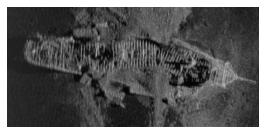

In [ ]:
wandb.agent(sweep_id, train_model, count=20)

In [ ]:
api = wandb.Api(overrides={"project": "diu-phase2-demo", "entity": "awesome-team"})

artifact_type, artifact_name = "model", "model_checkpoint"
for version in api.artifact_versions(artifact_type, artifact_name):
  # Clean up all versions that don't have an alias such as 'latest'.
	# NOTE: You can put whatever deletion logic you want here.
  if len(version.aliases) == 0:
      version.delete()

In [ ]:
# Add a call to the get best run from a sweep
# Get the model logged with that run

In [ ]:
api = wandb.Api(overrides={"project": "diu-phase2-demo", "entity": "awesome-team"})
sweep = api.sweep("awesome-team/diu-phase2-demo/jhzpq6lz")
runs = sorted(sweep.runs,
              key=lambda run: run.summary.get("val_acc", 0), reverse=True)
best_run = runs[0]
file = best_run.file("model.onnx").download(replace=True)
for artifact in best_run.logged_artifacts():
  artifact_path = artifact.download()
  print(artifact_path)

./artifacts/train_split:v80
./artifacts/val_split:v11


wandb: Downloading large artifact pretrained_resnet50:v130, 91.98MB. 1 files... Done. 0:0:1.9


./artifacts/pretrained_resnet50:v130


wandb: Downloading large artifact model_checkpoint:v1810, 91.98MB. 1 files... Done. 0:0:2.1


./artifacts/model_checkpoint:v1810
./artifacts/run-idbls9tl-test_table:v0
./artifacts/source-idbls9tl:v0
